# Advanced Data Science Capstone

## Correlation of air pollution and Prevalence of Asthma bronchiale in Germany  

## Model definition: Cluster approaches

### The deliverables
The deliverables of the current stage:

 - The models: at least one deep learning and at least one non-deep learning algorithm
 - Compare and document models performance
 - At least one additional iteration in the process model involving at least the feature creation task and record impact on model performance (e.g. data normalizing, PCA, …)
 
###  Architectural Decisions Document (ADD)

 - The choice of specific technologies / frameworks 
 - All decisions should be documented in the ADD
 
###  Result of the stage

 - Save the notebook according to the process model’s naming convention
 - Proceed to the model training task 
 
 First of all the necessary libraries and the feature matrices created at the Feature Engineering stage are loaded:

### Model definition
As far as linear regression approach was unsuccessful, classification approaches will be used.
As a result class a feature, showing whether the county is of the high risk of the disease or not.
This **feature** can be constructed as e.g. **presence of the county in 75th quantile** of the disease:

xls sheet names:  ['Hintergrundinformationen', 'Daten']
      Region  Regions-ID  KV             Kreistyp  Wert  Bundeswert
0   Eisenach       16056  TH    Ländliches Umland   8.9         5.7
1  Sonneberg       16072  TH      Ländlicher Raum   8.7         5.7
2  Ammerland        3451  NI  Verdichtetes Umland   8.5         5.7
Length of the dataset:  402


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11b24fa90>]],
      dtype=object)

<Figure size 432x288 with 0 Axes>

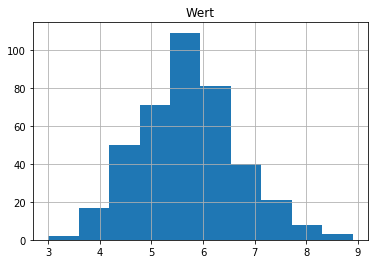

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn import decomposition
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm


FeatureSetDenseMean = pd.read_csv('Capstone.FeatureEng/Capstone.feature_eng.DenseMean.1.0.csv', index_col=None)
FeatureSetLongMean = pd.read_csv('Capstone.FeatureEng/Capstone.feature_eng.LongMean.1.0.csv', index_col=None)

FeatureSetDensePerc50 = pd.read_csv('Capstone.FeatureEng/Capstone.feature_eng.DensePerc50.1.0.csv', index_col=None)
FeatureSetDensePerc75 = pd.read_csv('Capstone.FeatureEng/Capstone.feature_eng.DensePerc75.1.0.csv', index_col=None)

FeatureSetLongPerc50 = pd.read_csv('Capstone.FeatureEng/Capstone.feature_eng.LongPerc50.1.0.csv', index_col=None)
FeatureSetLongPerc75 = pd.read_csv('Capstone.FeatureEng/Capstone.feature_eng.LongPerc75.1.0.csv', index_col=None)

xlsx_file = pd.ExcelFile("Capstone.rawData/Asthma_2016/data_id_92_kreis11_1_j_1451606400.xlsx")
print("xls sheet names: ",xlsx_file.sheet_names)
dfAsthma = xlsx_file.parse('Daten', header=3, decimal=",") 
print(dfAsthma.head(3))
print("Length of the dataset: ",len(dfAsthma))
plt.figure()
dfAsthma.hist(column='Wert')

### Additional feature creation

Additional feature for the disease prevalence is constructed as **presence of the county in Nth percentile** of the disease prevalence:

In [29]:
def DiseaseFeaturePercentile(DiseaseDF, Percentile):
    DiseasePercentile = (DiseaseDF['Wert']).quantile(Percentile/100.0)
    dfFeatureOut = pd.DataFrame(DiseaseDF['Regions-ID'])
    dfFeatureOut=dfFeatureOut.join((DiseaseDF['Wert'])>DiseasePercentile)
    dfFeatureOut.columns=['CountyID','DiseaseRFeat']
    return(dfFeatureOut)

dfAsthma50perc = DiseaseFeaturePercentile(dfAsthma, 50.0)
dfAsthma75perc = DiseaseFeaturePercentile(dfAsthma, 75.0)
dfAsthma95perc = DiseaseFeaturePercentile(dfAsthma, 95.0)

dfAsthma95perc.head()

,CountyID,DiseaseRFeat
0,16056,True
1,16072,True
2,3451,True
3,16073,True
4,3151,True


### Model Definition
A number of models, based on different feature sets are defined. Since the pollutant data sets are incomplete (do not include information about *all* German counties), the test/train sets will be cropped accordingly for each pollutant feature set:

In [26]:
dfAsthma75perc = DiseaseFeaturePercentile(dfAsthma, 75.0)
dfAsthma75perc.tail()

,CountyID,DiseaseRFeat
397,8417,False
398,9374,False
399,9272,False
400,8327,False
401,8127,False
